In [1]:
import sys
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [28]:
from src.modules import conf, fit, df_columns, evl, preprocess
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import gpxpy
import haversine as hs
import numpy as np
import statsmodels.api as sm
warnings.simplefilter("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [5]:
data = fit.load_pcls(
        athlete_name='zahradnik',
        activity_type='running',
        path_to_load=conf["Paths"]["pcl"],
    )

100%|██████████| 386/386 [00:00<00:00, 1746.40it/s]


In [308]:
race_index = fit.get_race_index(data, "2022-10-02-10-30") # HRADEC - 1:16 - 1:14
# race_index = fit.get_race_index(data, "2022-11-13-10-59") # VELKA KUNRATICKA 15:20 - 13:20
# race_index = fit.get_race_index(data, "2022-10-08-11-18") # BEROUNKA RUN 90:30 - 95:30
# race_index = fit.get_race_index(data, "2022-12-31-11-00") # SILVESTRAK 18:20 - 17:20
race_index

292

In [6]:
# train_df = fit.clean_data(pd.concat(data[0:len(data)-1]))[df_columns]
# test_df = fit.clean_data(pd.concat(data[len(data)-1:]))[df_columns]
# speed_train = train_df.enhanced_speed
# speed_valid = test_df.enhanced_speed

In [310]:
train_df = fit.clean_data(pd.concat(data[0:race_index]))[df_columns]
test_df = data[race_index]
speed_train = train_df.enhanced_speed
speed_valid = test_df.enhanced_speed
if len(train_df.columns) > len(test_df.columns):
    cols = list(test_df.columns)
else:
    cols = list(train_df.columns)
cols.pop(cols.index('enhanced_speed'))
train_df=train_df[cols]
test_df=test_df[cols]

In [311]:
len(train_df),len(test_df)

(586619, 4413)

In [312]:
from scipy.ndimage import uniform_filter1d
for x in range(10,110,10):
    train_df[f'moved_heart_rate_{x}'] = uniform_filter1d(train_df.heart_rate, size=x)
    test_df[f'moved_heart_rate_{x}'] = uniform_filter1d(test_df.heart_rate, size=x)

In [313]:
from feature_engine.datetime import DatetimeFeatures
train_df['date'] = train_df.index
test_df['date'] = test_df.index
dtf = DatetimeFeatures(features_to_extract=['month','week','hour','minute','second'])
train_df= dtf.fit_transform(train_df)
test_df= dtf.fit_transform(test_df)

In [314]:
from feature_engine.timeseries.forecasting import WindowFeatures
lagged_cols = ['heart_rate','cadence','slope_steep','slope_ascent','slope_descent']
lagged = 18
for lag in range(1,lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [315]:
for colname in train_df.columns:
    if 'mean' in colname:
        train_df[colname].fillna(0,inplace=True)
        test_df[colname].fillna(0,inplace=True)

In [316]:
# train_df=train_df[lagged:]
# test_df = test_df[lagged:]
# speed_train = speed_train[lagged:]
# speed_valid = speed_valid[lagged:]

1.2773325504138524


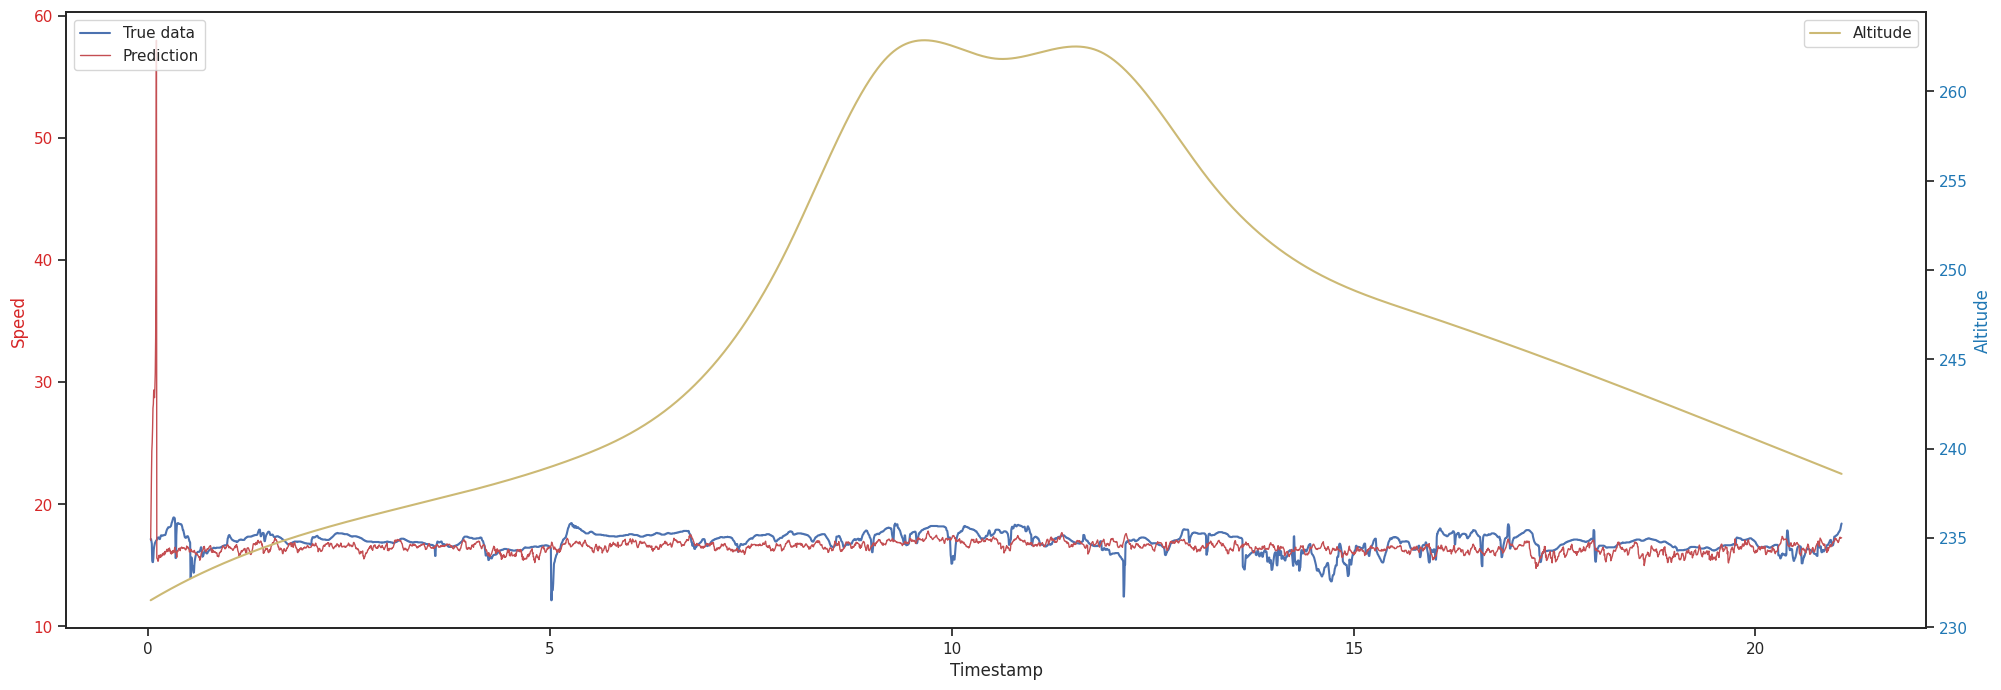

In [317]:
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV
clf = RidgeCV()
clf.fit(train_df, speed_train)
y_pred_ridge=clf.predict(test_df)
# y_pred_ridge = [y_pred_ridge[x] if y_pred_ridge[x] < 30 and y_pred_ridge[x] > 10 else np.mean(y_pred_ridge[x:x+30]) for x in range(len(y_pred_ridge))]
_, _ = evl.plot(df=test_df,pred=y_pred_ridge,endog='enhanced_speed',true_data=speed_valid)
print(evl.rmse(actual=speed_valid,predicted=y_pred_ridge))

In [318]:
import math
np.mean(speed_valid),np.mean(y_pred_ridge),max(test_df.distance)
time = ((max(test_df.distance)/1000) / np.mean(y_pred_ridge))*60
minutes = math.floor(time)
seconds = round((time-minutes)*60)
f'Final time: {minutes}:{seconds}'

'Final time: 76:36'

In [319]:
model = sm.OLS(speed_train, train_df)
model = model.fit()
# model.summary()

In [320]:
# cor = train_df.corr()
# plt.figure(figsize=(12,10))
# sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
# plt.show()

In [321]:
# sns.pairplot(
#     train_df[['heart_rate','distance','enhanced_altitude','cadence','temp','slope_steep']],
#     diag_kind='kde')

In [322]:
# train_df.to_pickle("./train_df.pcl")